In [151]:
# for this project, we are going to detect 20 different European languages. we are going to use 
#this dataset: http://www.statmt.org/europarl/
# we will work with pandas to create the right dataframe.

import pandas as pd
import os

# this dictionary will help us map file names to the exact language
lang_codes = {'German':'de','Danish':'da', 'Slovenian':'sl','Greek':'el', 
                'Spanish':'es', 'Finnish':'fi',
                'French':'fr', 'Italian':'it', 
                'Dutch': 'nl', 'Portuguese':'pt', 
                'Swedish':'sv', 'Bulgarian':'bg',
                'Czech':'cs', 'Estonian':'et',
                'Hungarian':'hu', 'Lithuanian':'lt',
                'Latvian':'lv', 'Polish':'pl',
                'Romanian':'ro', 'Slovak':'sk'}

# the directory that has language files in it
root_dir = '../lang_files'

# this dictionary is used to saved the sentences and their language as key, value pairs
target_dikt = {}

# we loop through all 20 language files and pick 50000 sentences from each language that are at least 30 charachters.
# since we have abundance of data, we limit each language to 50000 sentences
# Except Romanian because Romanian file has less thatn 50000 sentences

for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        string_file = str(file)
        lang = string_file[:2]
        for key, value in lang_codes.items():
            if value == lang:
                namee = key
        if lang != 'ro':
            path = os.path.join(subdir, file)
            with open(path, 'r', encoding = 'utf-8')as f:
                for i, line in enumerate(f):
                    if 10000<= i <= 60000:
                        if len(line)> 30:
                            target_dikt[line] = namee
                        
# just for Romanian file
with open('../lang_files/ro-en.txt', 'r', encoding = 'utf-8')as f:
    strr = 'Romanian'
    for i, line in enumerate(f):
        if 3000<= i <= 38000:
            if len(line)> 30:
                target_dikt[line] = strr

print(len(target_dikt))


939241


In [152]:
# we convert the target_dikt to a pandas dataframe
data = pd.DataFrame(list(target_dikt.items()),columns=['text', 'language'])
data.tail()


,text,language
939236,(Şedinţa a fost suspendată la ora 20.05 şi rel...,Romanian
939237,Structuri de îngrijire a copiilor - obiectivel...,Romanian
939238,Următorul punct pe ordinea de zi este declaraţ...,Romanian
939239,"membru al Comisiei -(CS) Doamnă preşedintă, do...",Romanian
939240,Aceste structuri sunt esenţiale pentru promova...,Romanian


In [153]:
# here we use regex expressions to remove all puctuations to have cleaner text
# an then we shuffle all the rows

import re
data['cleaned'] = data['text'].apply(lambda x: " ".join([i for i in re.sub("[<(!?).,*>]", " ", x).split()]))
data = data.sample(frac=1).reset_index(drop=True)

data.head()

,text,language,cleaned
0,"Mēs sagaidām, ka Turcija turpinās rīkoties kon...",Latvian,Mēs sagaidām ka Turcija turpinās rīkoties kons...
1,Lai gan strādājošo aizsardzībā absolūti būtisk...,Latvian,Lai gan strādājošo aizsardzībā absolūti būtisk...
2,"Sie soll auch nicht die Möglichkeit haben, una...",German,Sie soll auch nicht die Möglichkeit haben unan...
3,Suurten järvien alueen ongelmat koskevat useit...,Finnish,Suurten järvien alueen ongelmat koskevat useit...
4,Konkurencija nėra skirtingų asmenybių ar tapat...,Lithuanian,Konkurencija nėra skirtingų asmenybių ar tapat...


In [154]:
# at this stage, we map each language to an integer since the labels must be in numerical format 

label_encoding = { 
                  'Swedish':12, 'Bulgarian':13, 'Czech':14,'Estonian':15, 'Hungarian':16, 'Lithuanian':17,
    'Latvian':18, 'Polish':19, 'Romanian':20, 'Slovak':3, 'Slovenian':1,'Danish':2,'German':5, 'Spanish':6,
    'Finnish':7, 'French':8, 'Italian':9, 'Dutch':10, 'Portuguese':11,'Greek':4}

data['code'] = data['language'].map(label_encoding)
print(data.isnull().any())

text        False
language    False
cleaned     False
code        False
dtype: bool


In [156]:
data.tail(10)

,text,language,cleaned,code
939231,"On hyvin tärkeää, että tällä alalla päästään e...",Finnish,On hyvin tärkeää että tällä alalla päästään et...,7
939232,Μέσω του ρόλου των διαρθρωτικών πολιτικών και ...,Greek,Μέσω του ρόλου των διαρθρωτικών πολιτικών και ...,4
939233,Und schließlich hat die Kommission in jüngster...,German,Und schließlich hat die Kommission in jüngster...,5
939234,Η κοινωνική ατζέντα θα επιτρέψει να καθοριστεί...,Greek,Η κοινωνική ατζέντα θα επιτρέψει να καθοριστεί...,4
939235,"v imenu skupine UEN. - Gospod predsednik, skup...",Slovenian,v imenu skupine UEN - Gospod predsednik skupaj...,1
939236,Want zonder goed octrooirecht geen nieuwe inve...,Dutch,Want zonder goed octrooirecht geen nieuwe inve...,10
939237,"Гжо Председател, третирането и дискриминацията...",Bulgarian,Гжо Председател третирането и дискриминацията ...,13
939238,Niin syntyivät kaikki nämä asiat.\n,Finnish,Niin syntyivät kaikki nämä asiat,7
939239,V záujme rovnakého zaobchádzania by som však c...,Slovak,V záujme rovnakého zaobchádzania by som však c...,3
939240,La pronta risposta che ho ricevuto nell' incon...,Italian,La pronta risposta che ho ricevuto nell' incon...,9


In [157]:
# we split the data into training and testing sets

from sklearn.model_selection import train_test_split

language_features = data['cleaned']
language_targets = data['code']

X_train, X_test, y_train, y_test = train_test_split(language_features, 
                                                    language_targets,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [158]:
# our approach is to convert each sentence to vectors of term weights. machine learning algorithms work with 
# numbers so natural text must be changed into vector format. we apply term frequency-inverse document frequency (tfidf)
# to create vectors of term weights from each sentence.
# next, we use MultinomialNB classification algorithm (supervised learning) to fit our model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import  confusion_matrix, classification_report


tfidf_vect = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
model = MultinomialNB()
clf = Pipeline([('tfidf', tfidf_vect),('clf', model),])

clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [159]:
# now let's see how the model performs

predictions = clf.predict(X_test)

print(classification_report(y_test, predictions, target_names=label_encoding.keys()))

             precision    recall  f1-score   support

    Swedish       1.00      1.00      1.00     11903
  Bulgarian       1.00      1.00      1.00     11807
      Czech       1.00      1.00      1.00     11728
   Estonian       1.00      1.00      1.00     12100
  Hungarian       1.00      1.00      1.00     12133
 Lithuanian       1.00      1.00      1.00     12039
    Latvian       1.00      1.00      1.00     11819
     Polish       1.00      1.00      1.00     12013
   Romanian       1.00      1.00      1.00     11972
     Slovak       1.00      1.00      1.00     12124
  Slovenian       1.00      1.00      1.00     12233
     Danish       1.00      1.00      1.00     11914
     German       1.00      1.00      1.00     11964
    Spanish       1.00      1.00      1.00     11841
    Finnish       1.00      1.00      1.00     11696
     French       1.00      1.00      1.00     11716
    Italian       1.00      1.00      1.00     11682
      Dutch       1.00      1.00      1.00   

In [160]:
# so the accuarcy is kinda perfect, 100%. but we can check if it really is that good by testing the model on the 
# test data that the main website has provided.
# lets have a look at the test data

dff = pd.read_csv('europarl-Copy.csv', sep='\t', names=['language', 'text'])

In [161]:
dff.head()

,language,text
0,bg,Европа 2020 не трябва да стартира нов конкурен...
1,bg,(CS) Най-голямата несправедливост на сегашната...
2,bg,"(DE) Г-жо председател, г-н член на Комисията, ..."
3,bg,"(DE) Г-н председател, бих искал да започна с к..."
4,bg,"(DE) Г-н председател, въпросът за правата на ч..."


In [162]:
# we just need to invert the lang_codes dictionary

inv_map = {v: k for k, v in lang_codes.items()}
dff['lang'] = dff['language'].map(inv_map)
dff.head()

,language,text,lang
0,bg,Европа 2020 не трябва да стартира нов конкурен...,Bulgarian
1,bg,(CS) Най-голямата несправедливост на сегашната...,Bulgarian
2,bg,"(DE) Г-жо председател, г-н член на Комисията, ...",Bulgarian
3,bg,"(DE) Г-н председател, бих искал да започна с к...",Bulgarian
4,bg,"(DE) Г-н председател, въпросът за правата на ч...",Bulgarian


In [163]:
# we apply the same text cleanning methods as we used previousy

dff['cleaned'] = dff['text'].apply(lambda x: " ".join([i for i in re.sub("[<(!?).,*>]", " ", x).split()]))
dff = dff.sample(frac=1).reset_index(drop=True)

dff['label'] = dff['lang'].map(label_encoding)
print(data.isnull().any())

text        False
language    False
cleaned     False
code        False
dtype: bool


In [164]:
dff.tail(10)

,language,text,lang,cleaned,label
19818,cs,Přechod od předcházení incidentům k opatřením ...,Czech,Přechod od předcházení incidentům k opatřením ...,14
19819,da,Men hvis man foregiver at ville anvende det fr...,Danish,Men hvis man foregiver at ville anvende det fr...,2
19820,it,Dobbiamo andare avanti con questa alternanza d...,Italian,Dobbiamo andare avanti con questa alternanza d...,9
19821,sl,Dejansko želim videti nekakšno plačilo v oblik...,Slovenian,Dejansko želim videti nekakšno plačilo v oblik...,1
19822,fi,Pyytäisin häntä ennen huomista äänestystä kier...,Finnish,Pyytäisin häntä ennen huomista äänestystä kier...,7
19823,fi,Jos pyrimme todellakin Euroopan unionissa yhä ...,Finnish,Jos pyrimme todellakin Euroopan unionissa yhä ...,7
19824,sv,Jag har meddelat kammaren detta skäl.,Swedish,Jag har meddelat kammaren detta skäl,12
19825,pt,Ela actua sobretudo através de directrizes e r...,Portuguese,Ela actua sobretudo através de directrizes e r...,11
19826,sk,v mene skupiny PPE-DE. - (ES) Vážený pán preds...,Slovak,v mene skupiny PPE-DE - ES Vážený pán predseda...,3
19827,pl,"Z zadowoleniem przyjmuję fakt, że art. 31 spra...",Polish,Z zadowoleniem przyjmuję fakt że art 31 sprawo...,19


In [165]:
langs = dff['cleaned']
targs = dff['label']

preds = clf.predict(langs)

In [166]:
print(classification_report(targs, preds, target_names=label_encoding.keys()))

             precision    recall  f1-score   support

    Swedish       1.00      1.00      1.00      1000
  Bulgarian       1.00      1.00      1.00      1000
      Czech       0.99      1.00      1.00       929
   Estonian       1.00      1.00      1.00       992
  Hungarian       1.00      1.00      1.00      1000
 Lithuanian       1.00      1.00      1.00      1000
    Latvian       1.00      1.00      1.00      1000
     Polish       1.00      1.00      1.00      1000
   Romanian       1.00      1.00      1.00      1000
     Slovak       1.00      1.00      1.00      1000
  Slovenian       1.00      1.00      1.00      1000
     Danish       1.00      1.00      1.00      1000
     German       1.00      1.00      1.00      1000
    Spanish       1.00      0.99      1.00      1000
    Finnish       1.00      1.00      1.00      1000
     French       1.00      1.00      1.00      1000
    Italian       1.00      1.00      1.00      1000
      Dutch       1.00      1.00      1.00   

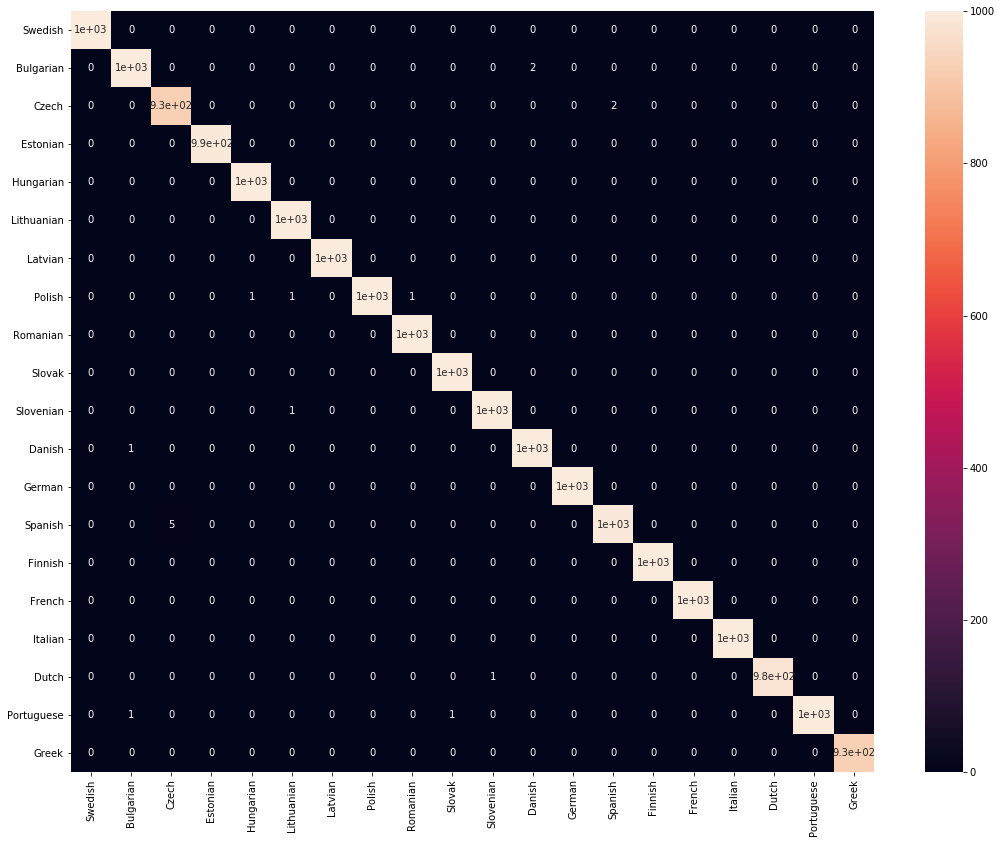

In [167]:
# well, we can see this model also performs very well on the unseen test set.
# now lets have a look at the confusion matrix.

import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(targs, clf.predict(langs))
cm_df = pd.DataFrame(cm, index = label_encoding.keys(), columns = label_encoding.keys())
plt.figure(figsize = (18,14))
sns.heatmap(cm_df, annot = True)

plt.show()